# Spam Email Classification with Logistic Regression (From Scratch Using NumPy)

In this project, we build a logistic regression model **from scratch using NumPy** to classify email messages as **spam** (1) or **ham** (0).

### Why This Project?
Spam detection is a classic **binary classification problem** in machine learning. This dataset from Kaggle's [Spam Email Classification Dataset](https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset) includes real emails from:
- **2007 TREC Public Spam Corpus**
- **Enron-Spam Dataset**

Our goal is to:
- Clean and prepare the text data
- Extract features using a simple bag-of-words approach
- Implement logistic regression manually using NumPy
- Evaluate model performance and interpret results

> This project demonstrates both **algorithm-level understanding** and **practical feature engineering for text classification**.


## 1. Import Libraries

In [1]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Preprocessing
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

## 2: Load Dataset

In [2]:
# Import data from csv file in the directory
df = pd.read_csv('combined-data.csv')

# Subsample 10,000 rows for faster training
df = df.sample(n=1000, random_state=42).reset_index(drop=True)

# Preview the data
df.head()

,label,text
0,0,accuweather escapenumber day forecast for beve...
1,1,dear in christ the time has come for christian...
2,1,hallway cosponsor pry reimbursable coat clumsy...
3,1,does size matter' escapenumber of women said t...
4,0,along zeng wrote hi all is there levene' test ...


## 3. Text Cleaning

The raw email messages contain punctuation, symbols, uppercase letters, and extra whitespace — all of which can interfere with feature extraction.

We apply a custom cleaning function to:
- Lowercase the text
- Remove non-alphanumeric characters
- Normalize whitespace

This creates a `clean_text` column we’ll use for vectorization.


In [3]:
# Cleaning function
def clean_text(text):
    """
    Clean the text to make it ready for machine learning.
    :param text: string to be cleaned
    :return: string with cleaned text
    """
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove punctuation/symbols
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text


# Apply text cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Quick preview
df.head()

,label,text,clean_text
0,0,accuweather escapenumber day forecast for beve...,accuweather escapenumber day forecast for beve...
1,1,dear in christ the time has come for christian...,dear in christ the time has come for christian...
2,1,hallway cosponsor pry reimbursable coat clumsy...,hallway cosponsor pry reimbursable coat clumsy...
3,1,does size matter' escapenumber of women said t...,does size matter escapenumber of women said th...
4,0,along zeng wrote hi all is there levene' test ...,along zeng wrote hi all is there levene test i...


## 4. Converting Text to Features: Bag-of-Words

To train our model, we need to turn text into numbers. We use the **Bag-of-Words (BoW)** model, which:

- Builds a vocabulary of the most frequent words
- Represents each email as a vector of word counts
- Ignores word order but captures frequency

We use `CountVectorizer` from `sklearn`, limited to 3,000 features for efficiency.

This gives us a feature matrix of shape `(num_emails, 3000)`, ready for logistic regression.


In [4]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(max_features=3000)

# Fit and transform the cleaned text into features
X = vectorizer.fit_transform(df['clean_text']).toarray()

# Labels
y = df['label'].values

# Preview
print("Vocabulary size:", len(vectorizer.vocabulary_))
print("First row vector (email 0):\n", X[0])

Vocabulary size: 3000
First row vector (email 0):
 [0 0 0 ... 0 0 0]


### 6. Train-Test Split

To evaluate our model fairly, we split the data into:

- **Training set (80%)**: Used to train the model
- **Test set (20%)**: Used to evaluate performance on unseen data

We use `train_test_split` from scikit-learn to perform the split.


In [5]:
# Split the data for train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preview the shape of the datasets
print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Train set size: 800
Test set size: 200


## 5. Training Logistic Regression (From Scratch)

We now train a logistic regression model using only NumPy. The model learns to classify emails as spam or ham by minimizing the binary cross-entropy loss using gradient descent.

We initialize weights to zero, compute gradients each step, and update using the learning rate.

Loss is tracked to monitor convergence.


### 5.1 Sigmoid Function

The sigmoid function maps any real number into a range between 0 and 1. It’s used in logistic regression to convert the linear combination of inputs into a probability.

The formula is:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

We clip the input `z` to prevent numerical overflow when computing large exponential.

This allows us to interpret the model output as the probability that a given email is spam (1) or ham (0).


In [6]:
# Define sigmoid function
def sigmoid(z):
    """
    Maps any real number into a range between 0 and 1.
    :param z: float value to be mapped
    :return: float value between 0 and 1
    """
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

### 5.2 Cost Function (Binary Cross-Entropy)

We use **binary cross-entropy loss** to measure how well our logistic regression model is predicting the true labels.

The loss function is:

$$
J(w, b) = - \frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) \right]
$$

Where:
- $ \hat{y}^{(i)} $ is the model's predicted probability for sample $ i $
- $ y^{(i)} $ is the true label (0 or 1)

We clip \( \hat{y} \) values to avoid taking the log of 0, which would cause numerical errors.


In [7]:
# Define the cost function
def compute_cost(X, y, w, b, lambda_):
    m = X.shape[0]
    z = np.dot(X, w) + b
    y_hat = sigmoid(z)

    # Add small value to avoid log(0)
    epsilon = 1e-15
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)

    cost = -(1 / m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    regularization = (lambda_ / (2 * m)) * np.sum(w ** 2)
    return cost + regularization

### 5.3 Training with Gradient Descent

We use **batch gradient descent** to minimize the binary cross-entropy cost and learn the model parameters:

- `w`: weights for each feature (i.e., word)
- `b`: the bias term

Each iteration involves:
1. Computing predicted probabilities using the sigmoid function
2. Calculating the gradients of the loss with respect to `w` and `b`
3. Updating the weights and bias using the learning rate

We track the cost after every iteration to monitor convergence. Training stops early if the change in cost is very small.


In [8]:
# Gradient descent function
def train_logistic_regression(X, y, learning_rate=0.1, iterations=1000, lambda_=0.1):
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    costs = []

    for i in range(iterations):
        z = np.dot(X, w) + b
        y_hat = sigmoid(z)

        # Gradients
        dw = (1 / m) * np.dot(X.T, (y_hat - y))
        db = (1 / m) * np.sum(y_hat - y)

        # Update weights
        w -= learning_rate * dw
        b -= learning_rate * db

        # Track cost
        cost = compute_cost(X, y, w, b, lambda_)
        costs.append(cost)

        if i % 100 == 0 or i == iterations - 1:
            print(f"Iteration {i}: Cost = {cost:.4f}")
        
        # Converging condition    
        if i > 1 and abs(costs[-1] - costs[-2]) < 1e-06:
            print(f"Converged at iteration {i}.")
            break

    return w, b, costs

## 6. Model Evaluation

We evaluate the model on the **test set** using:
- **Accuracy**: The percentage of correct predictions
- **Confusion matrix**: How many spams and hams were correctly/incorrectly classified
- **Classification report**: Includes precision, recall, and F1-score

The model uses a threshold of 0.5 to classify probabilities as spam (1) or ham (0).


### 6.1 Predict Function

The `predict` function uses the trained weights `w` and bias `b` to make predictions on new data.

It follows these steps:
1. Computes the linear combination:  
   $$
   z = w \cdot x + b
   $$
2. Applies the **sigmoid** function to convert `z` into probabilities between 0 and 1
3. Classifies each example:
   - If $ \hat{y} \geq 0.5 $, it's classified as **spam (1)**
   - If $ \hat{y} < 0.5 $, it's classified as **ham (0)**

This function returns the final predicted labels for each input sample.


In [9]:
# Define predict function
def predict(X, w, b):
    """
    Predicts whether an email vector is a spam or ham.
    :param X: 
    :param w: vector of trained weights
    :param b: float of trained bias
    :return: vector of labeled values 0 or 1
    """
    z = np.dot(X, w) + b
    y_hat = sigmoid(z)
    return np.where(y_hat > 0.5, 1, 0)

### 6.2 Accuracy Function

The `accuracy` function evaluates the performance of our logistic regression model by comparing the predicted labels to the actual labels.

It calculates:

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Predictions}}
$$

This gives a simple metric — expressed as a percentage — showing how well the model performed on the test set.


In [10]:
# Define accuracy function
def accuracy(y_pred, y_test):
    """
    Calculates the accuracy of the predictions.
    :param y_pred: vector of predicted values
    :param y_test: vector of true values
    :return: float accuracy of the predictions
    """
    return np.mean(y_pred == y_test)

### 6.3 Train the model, Run Predictions and Tests

In [11]:
# Train on X_train, y_train
w, b, costs = train_logistic_regression(X_train, y_train, learning_rate=0.01, iterations=10000, lambda_=10.0)

Iteration 0: Cost = 0.6667
Iteration 100: Cost = 0.4056
Iteration 200: Cost = 0.3364
Iteration 300: Cost = 0.2973
Iteration 400: Cost = 0.2710
Iteration 500: Cost = 0.2518
Iteration 600: Cost = 0.2369
Iteration 700: Cost = 0.2251
Iteration 800: Cost = 0.2154
Iteration 900: Cost = 0.2073
Iteration 1000: Cost = 0.2005
Iteration 1100: Cost = 0.1947
Iteration 1200: Cost = 0.1896
Iteration 1300: Cost = 0.1853
Iteration 1400: Cost = 0.1815
Iteration 1500: Cost = 0.1781
Iteration 1600: Cost = 0.1751
Iteration 1700: Cost = 0.1725
Iteration 1800: Cost = 0.1702
Iteration 1900: Cost = 0.1681
Iteration 2000: Cost = 0.1663
Iteration 2100: Cost = 0.1646
Iteration 2200: Cost = 0.1632
Iteration 2300: Cost = 0.1619
Iteration 2400: Cost = 0.1607
Iteration 2500: Cost = 0.1597
Iteration 2600: Cost = 0.1588
Iteration 2700: Cost = 0.1580
Iteration 2800: Cost = 0.1573
Iteration 2900: Cost = 0.1566
Iteration 3000: Cost = 0.1561
Iteration 3100: Cost = 0.1556
Iteration 3200: Cost = 0.1552
Iteration 3300: Cost =

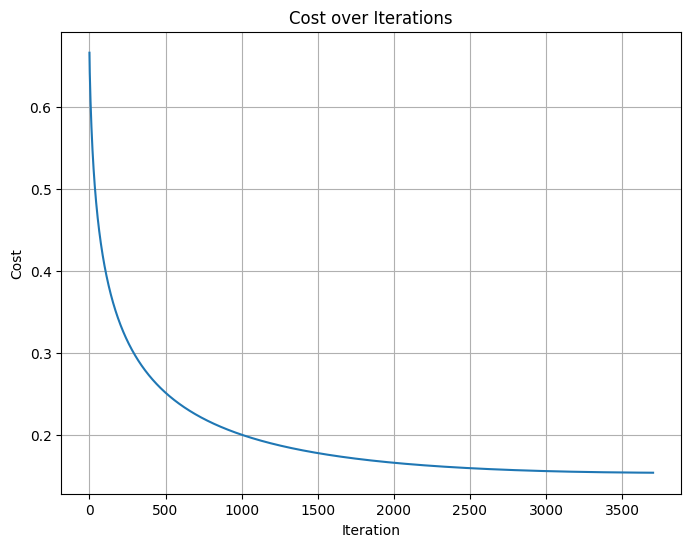

In [12]:
# Visualize the cost reduction
plt.figure(figsize=(8, 6))
plt.plot(costs)
plt.title("Cost over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

In [13]:
# Predict on test set
y_pred_test = predict(X_test, w, b)

# Calculate accuracy
acc = accuracy(y_pred_test, y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")

Test Accuracy: 93.00%


## Conclusion

In this project, we built a logistic regression model **from scratch using NumPy** to classify emails as spam or ham using real-world data from the TREC 2007 and Enron Spam corpora.

We went beyond library usage and implemented every core component manually:
- Cleaned and preprocessed thousands of raw email messages
- Converted text to numerical features using the Bag-of-Words model
- Implemented logistic regression with gradient descent
- Tracked model performance and visualized cost reduction over time
- Applied L2 regularization to improve generalization
- Evaluated our model using accuracy, confusion matrix, and classification report

This hands-on project deepened understanding of:
- Binary classification with logistic regression
- Working with text data in machine learning
- The importance of feature scaling, regularization, and careful evaluation

**Thanks for reading!**
